In [1]:

import matplotlib.pyplot as plt
import numpy as np
import blip_analysis as ba
import pickle
from matplotlib.gridspec import GridSpec
from sklearn.metrics import confusion_matrix
import exp_blip_models as em
import matplotlib
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance_matrix
from label_axes import label_axes
import json
import scipy
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

b


In [36]:
### Load in some data including the full classifier results

full_res = pickle.Unpickler(open('../Data/230315_full_classifier_RFs.pkl', 'rb')).load()
glyphs = ba.get_glyphs()
scores = full_res[:, :, 0].astype(float)
preds = full_res[:, :, 1]
preds_corrected = np.array([[np.stack(i) for i in j] for j in preds])
preds_flat = preds_corrected.reshape((preds_corrected.shape[0], preds_corrected.shape[1] * preds_corrected.shape[2]))

### These are the distance embeddings for the 3 odours
res1 = np.load('../Fig2/221026_de_1d_res_odour1_extended.npy')
res2 = np.load('../Fig2/221027_de_1d_res_odour2_extended.npy')
res3 = np.load('../Fig2/221027_de_1d_res_odour3_extended.npy')
res1 = np.array(res1).reshape(50, 162, 32)
res2 = np.array(res2).reshape(50, 162, 32)
res3 = np.array(res3).reshape(50, 162, 32)
style_params = json.load(open('../Data/style_params.json', 'r'))
classifier_cmap = style_params['classifier_cm_color']
odour_labels = style_params['odour_labels']
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()
unit_usrt1 = unit_usrt1[good_indexes]
unit_usrt2 = unit_usrt2[good_indexes]
unit_usrt3 = unit_usrt3[good_indexes]

Found odour 1
Found odour 3
Found odour 5


In [3]:
### Make connfusion matrices
trues = [i for j in range(100) for i in range(32)]
cms = np.array([confusion_matrix(trues, preds_flat[i], normalize='true') for i in range(3)])

In [4]:

### Flip the distances if needed
closests1 = [res1[0, 0]]
closests2 = [res2[0, 0]]
closests3 = [res3[0, 0]]
for i in range(1, 162):
    prev_distance = closests1[-1]
    diffs = np.mean(np.abs(res1[:, i] - prev_distance), axis=-1)
    min_diff = np.argmin(diffs)
    closests1.append(res1[min_diff, i])
    
    prev_distance = closests2[-1]
    diffs = np.mean(np.abs(res2[:, i] - prev_distance), axis=-1)
    min_diff = np.argmin(diffs)
    closests2.append(res2[min_diff, i])
    
    prev_distance = closests3[-1]
    diffs = np.mean(np.abs(res3[:, i] - prev_distance), axis=-1)
    min_diff = np.argmin(diffs)
    closests3.append(res3[min_diff, i])

In [70]:
def plot_1d_distance_graph(xs, distances, ax, colors=None, cmap=matplotlib.cm.plasma):
    '''Plot a 1d distance graph for part A'''

    distances = np.array(distances)
    trial_len = distances.shape[1]
    if colors is None:
        colors = [cmap(i/trial_len) for i in range(trial_len)]

    print(len(colors))
    for index, i in enumerate(distances.T):
        ax.plot(xs, i, color=colors[index])
    ax.axvspan(0, 0.1, color='lightgray')
    
def distance_plots(fig, gs_base, xs, closests, cmap=matplotlib.cm.plasma, hspace=0.5, fontsize=8):
    '''Overall plotting function for part A'''

    sub_gridspec = gs_base.subgridspec(ncols=14, nrows=2, wspace=1.5, hspace=hspace)
    big_ax = fig.add_subplot(sub_gridspec[0, 2:])
    small_ax1 = fig.add_subplot(sub_gridspec[1, 2:6])
    small_ax2 = fig.add_subplot(sub_gridspec[1, 6:10])
    small_ax3 = fig.add_subplot(sub_gridspec[1, 10:])
    
    small_ax2.set_yticklabels([])
    small_ax3.set_yticklabels([])
    plot_1d_distance_graph(xs, closests1, big_ax, cmap=cmap)

    cbar_ax = fig.add_subplot(sub_gridspec[:, 0])
    cbar_ax.yaxis.set_ticks_position('left')
    plot_cbar_and_glyphs(cbar_ax, glyphs, cmap.reversed(), fontsize=fontsize)
    cbar_ax.yaxis.set_ticks_position('left')
    plot_1d_distance_graph(xs[50:70], closests1[50:70], small_ax1, cmap=cmap)
    plot_1d_distance_graph(xs[50:70], closests2[50:70], small_ax2, cmap=cmap)
    plot_1d_distance_graph(xs[50:70], closests3[50:70], small_ax3, cmap=cmap)
    
    min_max = np.max(np.abs(np.concatenate([small_ax1.get_ylim(), small_ax2.get_ylim(), small_ax3.get_ylim()])))
    small_ax1.set_ylim(-min_max, min_max)
    small_ax2.set_ylim(-min_max, min_max)
    small_ax3.set_ylim(-min_max, min_max)
    label_ax = fig.add_subplot(sub_gridspec[:, 2:], frameon=False)
    label_ax.set_xticks([])
    label_ax.set_yticks([])
    label_ax.set_ylabel('Distance (Hz)', labelpad=27)
    label_ax.set_xlabel('Time (s)', labelpad=20)
    return [big_ax, small_ax1, small_ax2, small_ax3]
def plot_cbar_and_glyphs(ax, glyphs, cmap, fontsize=8):
    '''Plot the colorbar for part A'''
    im = ax.imshow(np.array([[0, 1]]), aspect=30, cmap=cmap)
    cbar = plt.colorbar(cax=ax, mappable=im)
    cbar.set_ticks(np.linspace(0, 1, len(glyphs)))
    cbar.set_ticklabels(glyphs[::-1])
    cbar.ax.tick_params(labelsize=fontsize)


In [59]:
### faux distance matrices

### Label each trial by either the onset or the concentration
labs_onset = np.where(em.trial_arrays['cao_array'][:, :5] == 1)[1]
labs_conc = np.where(em.trial_arrays['cao_array'][:, 5:] == 1)[1]
labs_conc = np.append([-1], labs_conc)
labs_onset = np.append([5], labs_onset)

### Construct the Distance matrices
dm_conc = distance_matrix(labs_conc[:, np.newaxis], labs_conc[:, np.newaxis])
dm_onset = distance_matrix(labs_onset[:, np.newaxis], labs_onset[:, np.newaxis])

def plot_faux_distance_matrices(fig, glob_gs, dms, glyphs, titles=None, cmap='viridis', rotate=False, cbar=True, fs=6):
    '''Plot the faux distance matrices for part E'''
    if cbar:
        sub_gs = glob_gs.subgridspec(ncols=22, nrows=2, hspace=0.3)
    else:
        sub_gs = glob_gs.subgridspec(ncols=20, nrows=2, hspace=0.3)
    axs = []
    max_dm = np.max([np.max(i) for i in dms])
    min_dm = np.min([np.min(i) for i in dms])
    for i, dm in enumerate(dms):
        if rotate:
            ax = fig.add_subplot(sub_gs[:, i*11:(i+1)*9+2*i])
        else:
            ax = fig.add_subplot(sub_gs[i, :20])
        im = ax.imshow(dm, cmap=cmap, vmax=max_dm, vmin=min_dm)
        
        ax.set_xticks(range(32))
        ax.set_yticks(range(32))
        ax.set_yticklabels(glyphs, fontsize=fs)
        ax.set_ylim(31.5, -0.5)
        if titles is not None:
            ax.set_title(titles[i])
        ax.set_xticklabels([])
        axs.append(ax)
    axs[1].set_xticklabels(glyphs, rotation=90, fontsize=fs)
    if rotate:
        #axs[1].set_yticklabels([])
        axs[0].set_xticklabels(glyphs, rotation=90, fontsize=fs)
    if cbar:
        cbar_ax = fig.add_subplot(sub_gs[:, -1])
        colorbar = fig.colorbar(im, cax=cbar_ax)
        axs.append(cbar_ax)
    return axs, im
def full_loss(x):
    ws = x @ em.trial_arrays['cao_array'].T
    dm = distance_matrix(ws[:, np.newaxis], ws[:, np.newaxis])
    return 1 - abs(np.corrcoef(dm.ravel(), cms[0].ravel())[0, 1])

### Find the optimized combo distance matrix
opt = scipy.optimize.minimize(full_loss, np.ones(10), method='Nelder-Mead', options={'maxiter':10000})
preds = opt.x @ em.trial_arrays['cao_array'].T
dm_combo = distance_matrix(preds[:, np.newaxis], preds[:, np.newaxis])


32
32
32
32


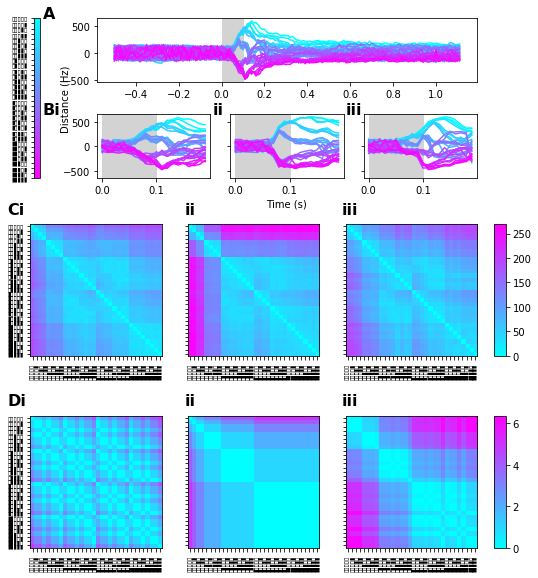

In [77]:
fig = plt.figure(figsize=(8, 10))
gs = fig.add_gridspec(3, 3)
xs = np.arange(-.5, 1.12, 1/100)
distance_axs = distance_plots(fig, gs[0, :], xs, closests1, cmap=matplotlib.cm.cool, fontsize=6)
dm_ax1 = fig.add_subplot(gs[1, 0])
dm_ax2 = fig.add_subplot(gs[1, 1])
dm_ax3 = fig.add_subplot(gs[1, 2])
vmax = np.max([dm1, dm2, dm3])
im = dm_ax1.imshow(dm1, cmap='cool', vmax=vmax)
dm_ax2.imshow(dm2, cmap='cool', vmax=vmax)
dm_ax3.imshow(dm3, cmap='cool', vmax=vmax)
[i.set_xticks(range(32)) for i in [dm_ax1, dm_ax2, dm_ax3]]
[i.set_yticks(range(32)) for i in [dm_ax1, dm_ax2, dm_ax3]]
[i.set_xticklabels(glyphs, rotation=90, fontsize=6) for i in [dm_ax1, dm_ax2, dm_ax3]];
[i.set_yticklabels([]) for i in [dm_ax1, dm_ax2, dm_ax3]];
dm_ax1.set_yticklabels(glyphs, fontsize=6);
[i.set_ylim(31.5, -0.5) for i in [dm_ax1, dm_ax2, dm_ax3]];
cbar_ax = fig.add_axes([0.93, 0.4, 0.02, 0.2])
plt.colorbar(im, cax=cbar_ax)
cbar_ax_pos = cbar_ax.get_position()
dm_ax3_pos = dm_ax3.get_position()
cbar_ax.set_position([cbar_ax_pos.x0, dm_ax3_pos.y0, cbar_ax_pos.width, dm_ax3_pos.height])


conc_ax = fig.add_subplot(gs[2, 0])
lat_ax = fig.add_subplot(gs[2, 1])
combo_ax = fig.add_subplot(gs[2, 2])
vmax = np.max([dm_conc, dm_onset, dm_combo])
conc_im = conc_ax.imshow(dm_conc, cmap='cool', vmax=vmax)
lat_im = lat_ax.imshow(dm_onset, cmap='cool', vmax=vmax)
combo_im = combo_ax.imshow(dm_combo, cmap='cool', vmax=vmax)
cbar_ax = fig.add_axes([0.93, 0.2, 0.02, 0.2])
plt.colorbar(conc_im, cax=cbar_ax)
cbar_ax_pos = cbar_ax.get_position()
combo_ax_pos = combo_ax.get_position()
cbar_ax.set_position([cbar_ax_pos.x0, combo_ax_pos.y0, cbar_ax_pos.width, combo_ax_pos.height])
[ax.set_xticks(range(32)) for ax in [conc_ax, lat_ax, combo_ax]]
[ax.set_yticks(range(32)) for ax in [conc_ax, lat_ax, combo_ax]]
[ax.set_xticklabels(glyphs, rotation=90, fontsize=6) for ax in [conc_ax, lat_ax, combo_ax]];
[ax.set_yticklabels([]) for ax in [conc_ax, lat_ax, combo_ax]];
conc_ax.set_yticklabels(glyphs, fontsize=6);
[ax.set_ylim(31.5, -0.5) for ax in [conc_ax, lat_ax, combo_ax]];

axes = [*distance_axs, dm_ax1, dm_ax2, dm_ax3, conc_ax, lat_ax, combo_ax]
labels = ['A', 'Bi', 'ii', 'iii', 'Ci', 'ii', 'iii', 'Di', 'ii', 'iii']
align_x = [[0, 1], [4, 7], [5, 8], [6, 9]]
align_y = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
dx = [-0.035, -0.035, -0.025, -0.025, 0, 0, 0, 0, 0, 0]
dy = [0, 0, 0, 0, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015]
label_axes.label_axes(axes, labels, fontsize=16, fontweight='bold', align_x=align_x, align_y=align_y, align_x_fun=np.min, align_y_fun=np.max, dx=dx, dy=dy)
plt.savefig('230823_Sup23.pdf', bbox_inches='tight')


In [10]:
print(res1.shape)

(50, 162, 32)


In [31]:
dm1 = distance_matrix(res1[3, 50:100].mean(axis=0).T, res1[3,50:100].mean(axis=0).T)
plt.imshow(dm1)

ValueError: not enough values to unpack (expected 2, got 1)

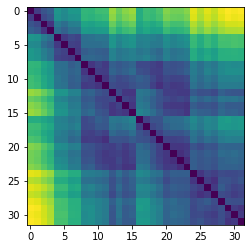

In [40]:
mean_usrt1 = np.array([[np.mean(i, axis=0) for i in j] for j in unit_usrt1])
mean_usrt2 = np.array([[np.mean(i, axis=0) for i in j] for j in unit_usrt2])
mean_usrt3 = np.array([[np.mean(i, axis=0) for i in j] for j in unit_usrt3])

dm1 = distance_matrix(mean_usrt1.mean(axis=-1).T, mean_usrt1.mean(axis=-1).T)
dm2 = distance_matrix(mean_usrt2.mean(axis=-1).T, mean_usrt2.mean(axis=-1).T)
dm3 = distance_matrix(mean_usrt3.mean(axis=-1).T, mean_usrt3.mean(axis=-1).T)
plt.imshow(dm3)

In [35]:
print(mean_usrt.shape)

(145, 32, 50)
